In [1]:
import os
import numpy as np
import pandas as pd
from functools import partial
from datetime import date
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, roc_auc_score, auc, roc_curve, accuracy_score

pd.set_option("display.max_columns", 10)
pd.set_option("display.width", 180)
DATA_PATH = "./data/ml100marathon-02-01/"


def label(row):
    value = 0
    if np.isnan(row["Date_received"]):
        value = -1
    if not np.isnan(row["Date"]):
        td = pd.to_datetime(row["Date"], format="%Y%m%d") - pd.to_datetime(row["Date_received"], format="%Y%m%d")
        if td <= pd.Timedelta(15, "D"):
            value = 1
    return value


def getWeekday(row):
    return row if (np.isnan(row)) or (row == -1) else str(int(pd.to_datetime(row, format="%Y%m%d").dayofweek) + 1)


def getWeekdayType(row):
    return 1 if row in ["6", "7"] else 0


def getDiscountType(row):
    value = 0
    if row == 'null':
        value = 'null'
    elif ':' in row:
        value = 1
    return value


def convertRate(row):
    if row == 'null':
        value = 1.0
    elif ':' in row:
        rows = row.split(':')
        value = 1.0 - float(rows[1]) / float(rows[0])
    else:
        value = float(row)
    return value


def getDiscountMan(row):
    return int(row.split(':')[0]) if ':' in row else 0


def getDiscountJian(row):
    return int(row.split(':')[1]) if ':' in row else 0


def split_train_valid(row, date_cut="20160416"):
    return True if pd.to_datetime(row, format="%Y%m%d") < pd.to_datetime(date_cut, format="%Y%m%d") else False

In [2]:
def dataProcess(df):
    df["weekday"] = df["Date_received"].apply(getWeekday)
    df["weekday_type"] = df["weekday"].astype(str).apply(getWeekdayType)
    # df = pd.concat([df.drop("weekday", axis=1), pd.get_dummies(df["weekday"].replace(-1, np.nan), prefix="weekday")], axis=1)
    df = pd.concat([df, pd.get_dummies(df["weekday"].replace(-1, np.nan), prefix="weekday")], axis=1)
    df["discount_rate"] = df["Discount_rate"].astype(str).apply(convertRate)
    df["discount_man"] = df["Discount_rate"].astype(str).apply(getDiscountMan)
    df["discount_jian"] = df["Discount_rate"].astype(str).apply(getDiscountJian)
    df["discount_type"] = df["Discount_rate"].astype(str).apply(getDiscountType)
    df.loc[df.Distance.isna(), "Distance"] = 99
    return df

In [9]:
def check_model(data, predictors):
#     classifier = partial(
#         SGDClassifier,
#         loss='log',
#         penalty='elasticnet',
#         fit_intercept=True,
#         max_iter=1000,
#         tol=1e-3,
#         shuffle=True,
#         n_jobs=1,
#         class_weight=None
#     )
    classifier = partial(
        GradientBoostingClassifier,
        random_state=1
    )
    
    model = Pipeline(steps=[
#         ('ss', StandardScaler()),
        ('mm', MinMaxScaler()),
        ('en', classifier())
    ])

    parameters = {
#         "en__alpha": [0.001, 0.01, 0.1],
#         "en__l1_ratio": [0.001, 0.01, 0.1],
        "en__n_estimators": [200, 300],
        "en__max_depth": [6, 8]
    }

    folder = StratifiedKFold(n_splits=5, shuffle=True)
    grid_search = GridSearchCV(model, parameters, cv=folder, scoring="neg_log_loss", iid=False, n_jobs=-1, verbose=1)
    grid_result = grid_search.fit(data[predictors].astype(float), data["label"].astype(float))
    gb_clf = GradientBoostingClassifier(max_depth=grid_result.best_params_["en__max_depth"], n_estimators=grid_result.best_params_["en__max_depth"])
    return gb_clf.fit(data[predictors].astype(float), data["label"].astype(float))

In [4]:
data_train = pd.read_csv(os.path.join(DATA_PATH, "train_offline.csv"))
data_test = pd.read_csv(os.path.join(DATA_PATH, "test_offline.csv"))
data_train["label"] = data_train.apply(label, axis=1)

In [5]:
data_train = dataProcess(data_train)
data_test = dataProcess(data_test)

df = data_train[data_train["label"] != -1].copy()
df["is_train"] = df["Date_received"].apply(split_train_valid)
train = df[df["is_train"]]
valid = df[~df["is_train"]]
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)

In [ ]:
#predictors = ["discount_rate", "discount_type", "discount_man", "discount_jian", "Distance", "weekday_type"] + ["weekday_{}".format(i + 1) for i in range(7)]
predictors = ["discount_rate", "discount_type", "discount_man", "discount_jian", "Distance", "weekday", "weekday_type"] + ["weekday_{}".format(i + 1) for i in range(7)]
model = check_model(train, predictors)
y_valid_pred = model.predict_proba(valid[predictors].astype(float))
valid_1 = valid.copy()
valid_1['pred_prob'] = y_valid_pred[:, 1]

auc_score = roc_auc_score(y_true=valid.label, y_score=y_valid_pred[:, 1])
acc = accuracy_score(y_true=valid.label, y_pred=y_valid_pred.argmax(axis=1))
print("Validation AUC: {:.3f}, Accuracy: {:.3f}".format(auc_score, acc))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [7]:
targetset = data_test.copy()
targetset = targetset[~targetset.Coupon_id.isna()]
targetset.reset_index(drop=True, inplace=True)
testset = targetset[predictors].copy()
y_test_pred = model.predict_proba(testset[predictors].astype(float))
test_1 = testset.copy()
test_1['pred_prob'] = y_test_pred[:, 1]

In [8]:
output = pd.concat((targetset[["User_id", "Coupon_id", "Date_received"]], test_1["pred_prob"]), axis=1)
output.loc[:, "User_id"] = output["User_id"].apply(lambda x: str(int(x)))
output.loc[:, "Coupon_id"] = output["Coupon_id"].apply(lambda x: str(int(x)))
output.loc[:, "Date_received"] = output["Date_received"].apply(lambda x: str(int(x)))
output["uid"] = output[["User_id", "Coupon_id", "Date_received"]].apply(lambda x: '_'.join(x.values), axis=1)
output.reset_index(drop=True, inplace=True)
out = output.groupby("uid", as_index=False).mean()
out = out[["uid", "pred_prob"]]
out.columns = ["uid", "label"]
out.to_csv('result/ml100marathon-02-01.csv', index=False)

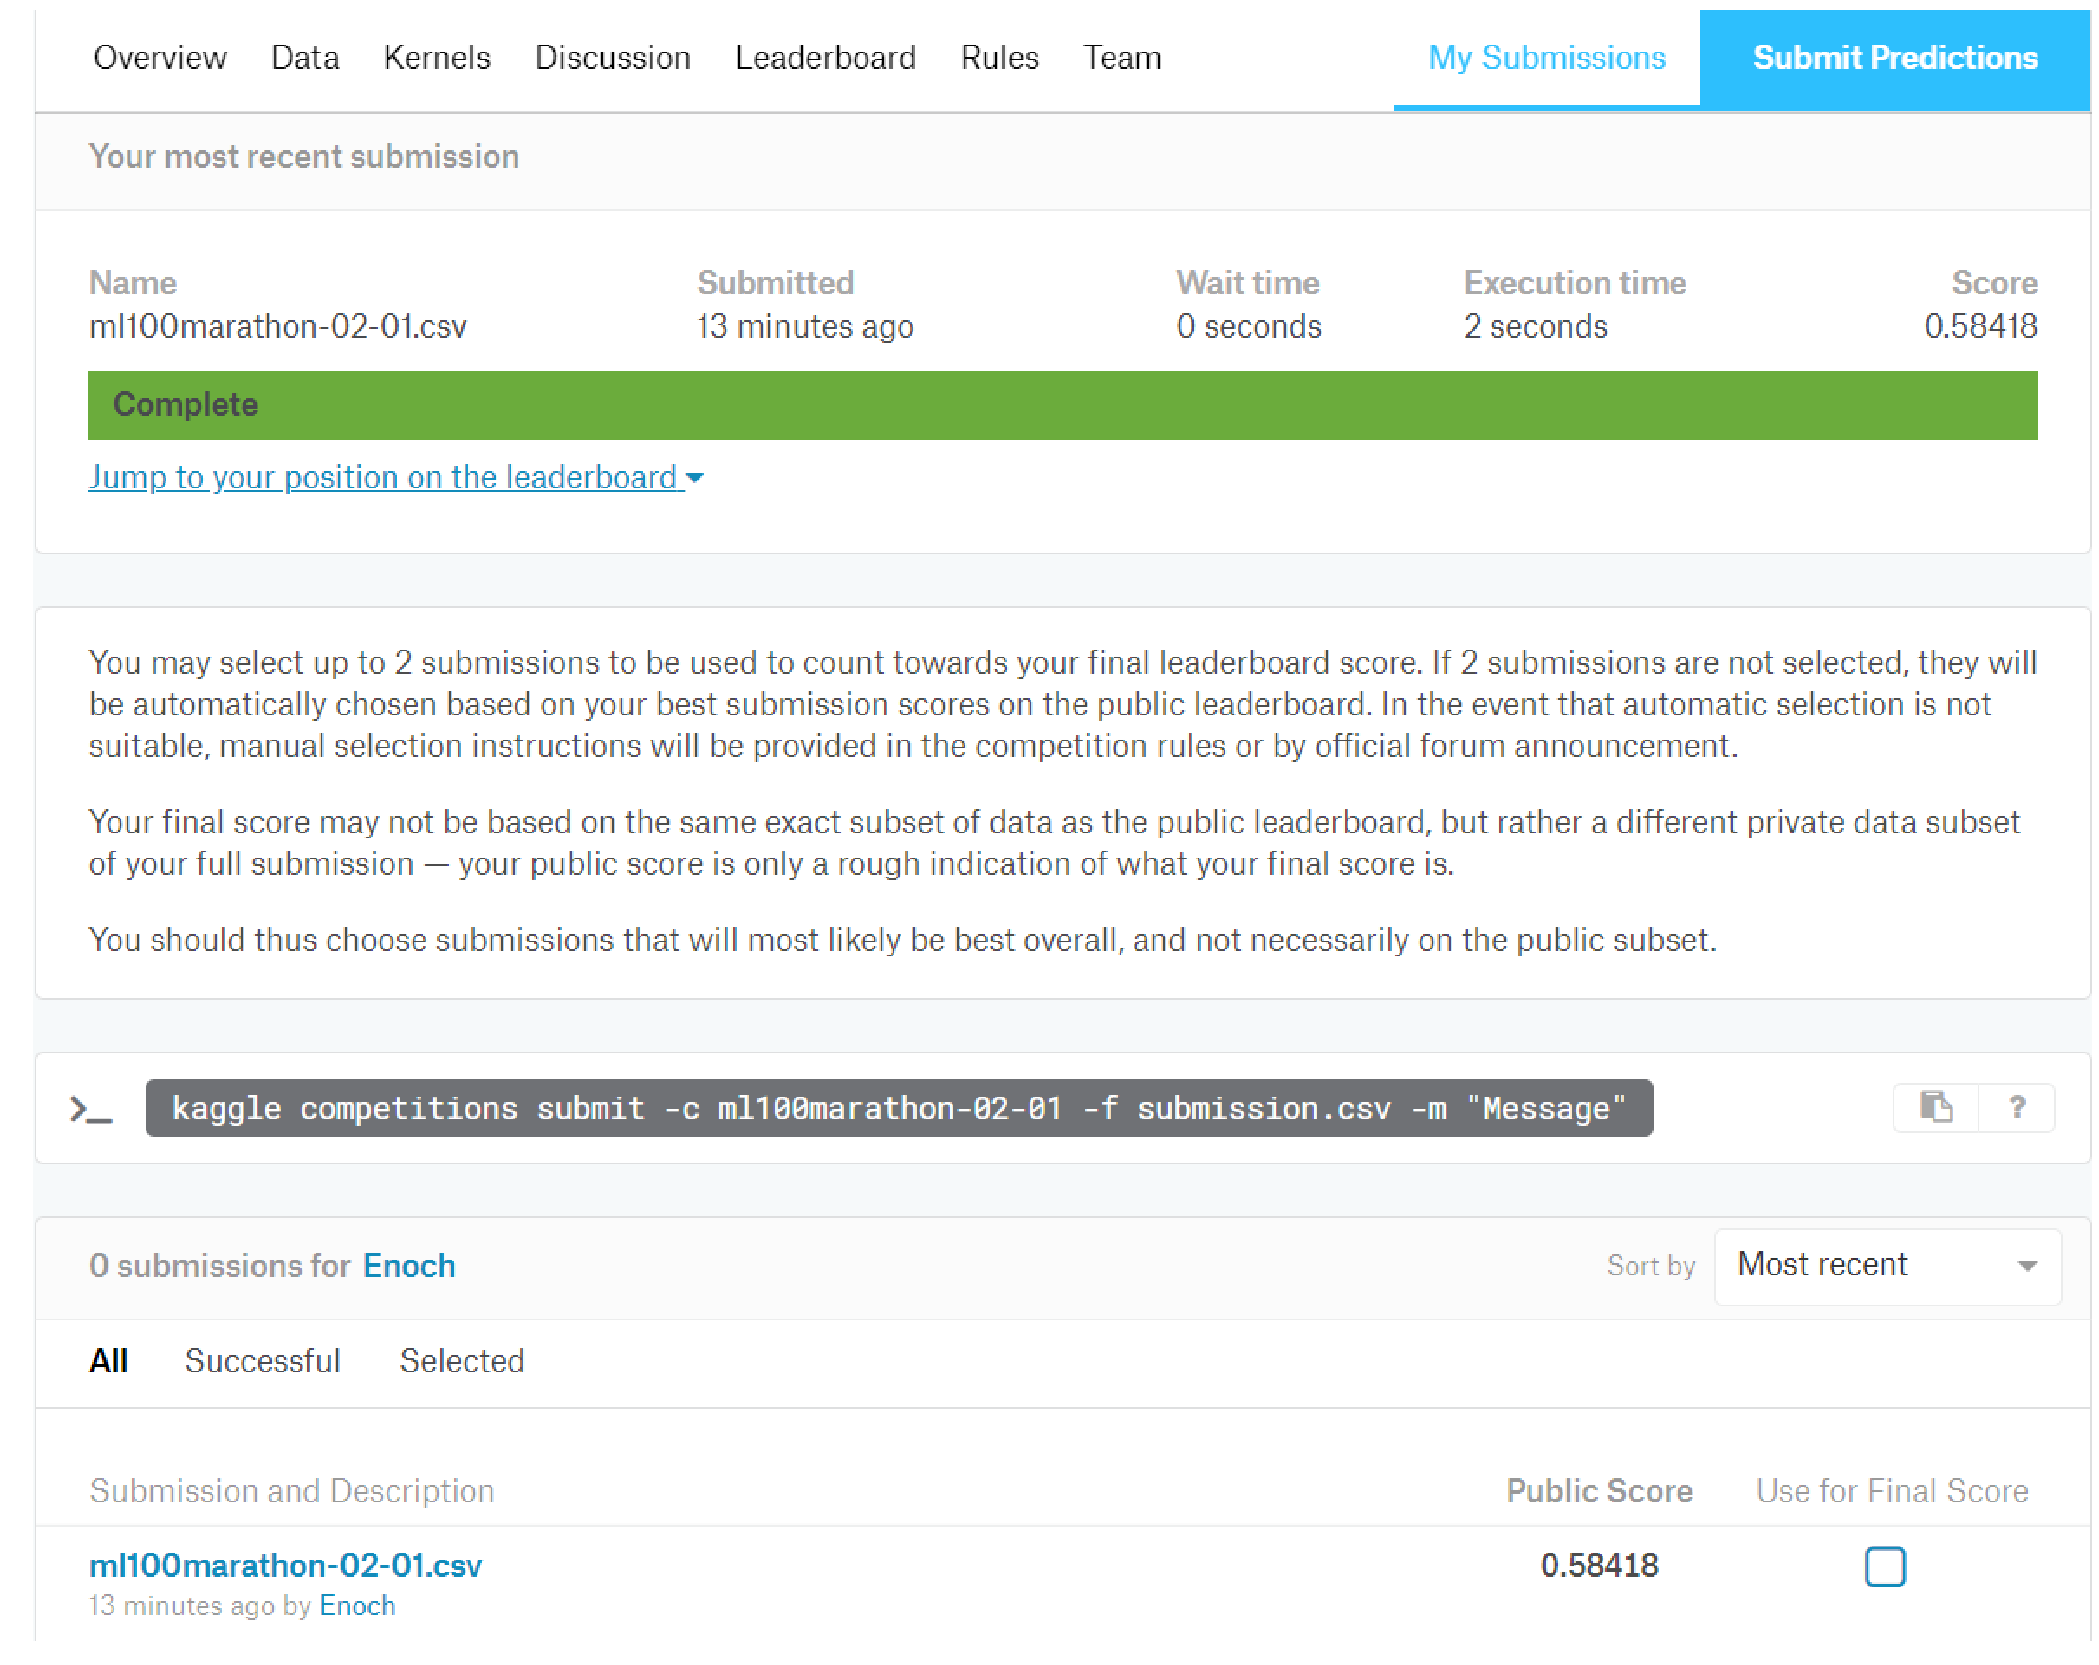

In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
img = plt.imread(os.path.abspath("./result/ml100marathon-02-01_snapshot.png"))
plt.figure(figsize=(40, 30))
plt.imshow(img)
plt.axis("off")
plt.show()